# Libraries and functions

In [1]:
## Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.colors import ListedColormap, Normalize, BoundaryNorm
plt.rcParams.update({'font.size': 14})
import random
import math


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator


from google.colab import drive
drive.mount('/content/gdrive')
data_PATH = "gdrive/MyDrive/Associative_memory/Cross_entropy_training/"

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cos = nn.CosineSimilarity(dim=-1)

device = torch.device("cpu")
print("Device:", device)

Mounted at /content/gdrive
Device: cpu


In [2]:
def fit_and_plot_powerlaw(x, y, ax=None, plot_kwargs=None, fit_kwargs=None):
    x = np.asarray(x)
    y = np.asarray(y)
    # 1) do the linear fit in log–log
    logx = np.log(x)
    logy = np.log(y)
    # gamma is slope, log(k) is intercept
    gamma, logk = np.polyfit(logx, logy, 1)
    k = np.exp(logk)

    # 2) plotting
    if ax is None:
        ax = plt.gca()
    if plot_kwargs is None:
        plot_kwargs = {}
    if fit_kwargs is None:
        fit_kwargs = {"linestyle":"--", "linewidth":2}

    # raw data
    ax.plot(x, y, label="data", **plot_kwargs)
    # fitted power-law
    ax.plot(x, k * x**gamma, label=f"fit", **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()

    return k, gamma


# Final plots in the paper

## **Main analysis**

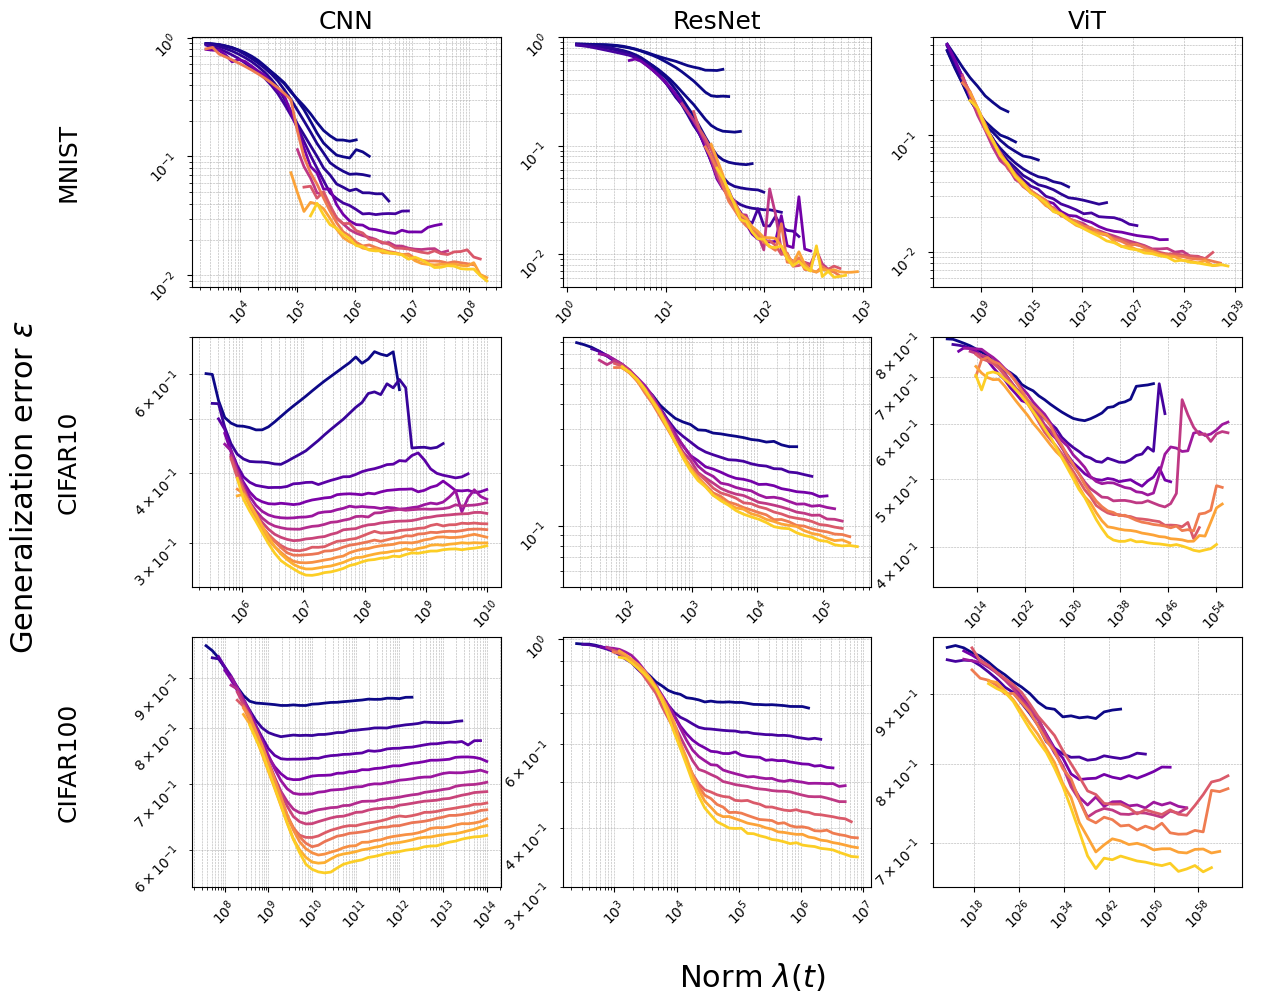

In [4]:
name_save = [
    "CNN_MNIST.npy", "ResNet_MNIST.npy", "ViT_MNIST.npy",
    "CNN_CIFAR10.npy", "ResNet_CIFAR10.npy", "ViT_CIFAR10.npy",
    "CNN_CIFAR100.npy", "ResNet_CIFAR100.npy", "ViT_CIFAR100.npy"
]
dataset_list = ["MNIST", "CIFAR10", "CIFAR100"]
model_list = ["CNN", "ResNet", "ViT"]
ylim_values = [
    (8e-3, 10.1e-1), (5e-3, 10e-1), (5e-3, 7e-1),
    (2.5e-1, 0.7), (5.e-2, 0.85), (3.5e-1, 0.8),
    (5.5e-1, 9.9e-1), (3e-1, 10.1e-1), (6.5e-1, 9.9e-1)
]



def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)



fig, axes = plt.subplots(3, 3, figsize=(14, 10))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)


y_positions = [1 - (i + 0.5) / 3 for i in range(3)]

for i, dataset in enumerate(dataset_list):
    for j, model in enumerate(model_list):
        idx = i * 3 + j

        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]
        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i, j]

        for k in range(len(mean_val_error_arr[:,0])):
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid, mean_val_error_arr[k], color=color, linewidth=2)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)

        if i == 0:
            ax.set_title(model, fontsize=18)

        if j == 0:
            ax.text(
                -0.4, 0.5, dataset,
                va='center', ha='center', rotation='vertical',
                transform=ax.transAxes, fontsize=18
            )
        ax.tick_params(axis='y', rotation=45, labelsize=12)
        ax.tick_params(axis='x', labelsize=12)



fig.text(0.5, 0., r"Norm $\lambda(t)$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)


for ax in axes.flatten():
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
        )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()


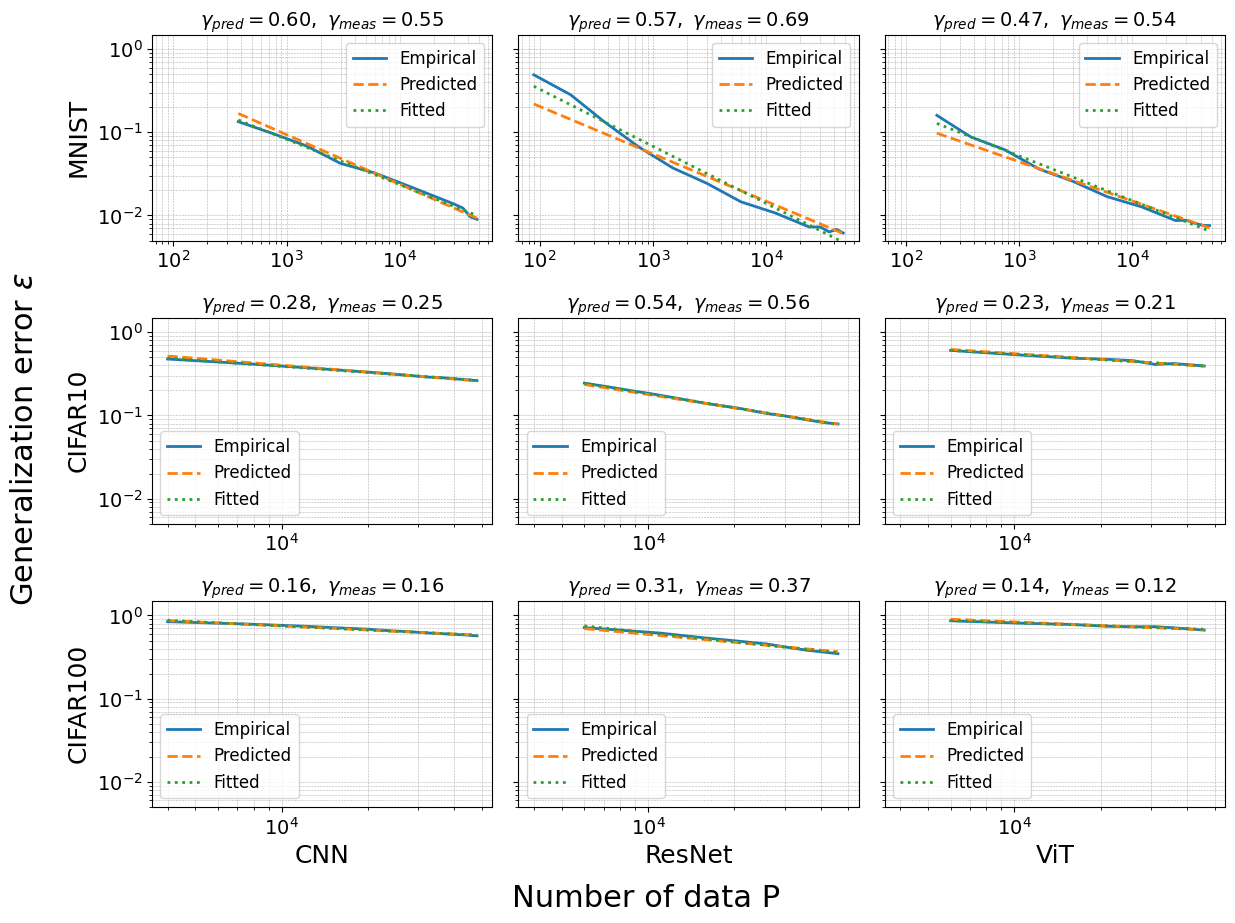

\begin{table}
\caption{Predicted vs. Measured Exponents}
\label{tab:error_exponents}
\begin{tabular}{llcc}
\toprule
Model & Dataset & gamma_pred & gamma_meas & stderr \\
\midrule
CNN & MNIST & 0.60 & 0.55 & 0.09 \\
CNN & CIFAR10 & 0.28 & 0.25 & 0.07 \\
CNN & CIFAR100 & 0.16 & 0.16 & 0.03 \\
ResNet & MNIST & 0.57 & 0.69 & 0.08 \\
ResNet & CIFAR10 & 0.54 & 0.56 & 0.04 \\
ResNet & CIFAR100 & 0.31 & 0.37 & 0.03 \\
ViT & MNIST & 0.47 & 0.54 & 0.03 \\
ViT & CIFAR10 & 0.23 & 0.21 & 0.03 \\
ViT & CIFAR100 & 0.14 & 0.12 & 0.04 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{gamma_1 and gamma_2 exponents}
\label{tab:error_exponents_2}
\begin{tabular}{llcccc}
\toprule
Model & Dataset & gamma_1 & err_gamma_1 & gamma_2 & err_gamma_2 \\
\midrule
CNN & MNIST & 0.5907 & 0.0632 & 1.0112 & 0.1138 \\
CNN & CIFAR10 & 0.2097 & 0.0114 & 1.3208 & 0.3226 \\
CNN & CIFAR100 & 0.1121 & 0.0027 & 1.4448 & 0.2243 \\
ResNet & MNIST & 1.1518 & 0.1422 & 0.4951 & 0.0236 \\
ResNet & CIFAR10 & 0.5314 & 0

In [5]:
from scipy.stats import linregress
import pandas as pd

x_to_take = [
    None, None, None,
    None, None, None,
    None, None, None
]

col_emp, col_pred, col_fit = "C0","C1","C2"
results = []
result_gamma = []


nD, nM = len(dataset_list), len(model_list)
fig, axes = plt.subplots(nD, nM, figsize=(4*nM, 3*nD),
                        sharex="row",
                        sharey=True)

for idx, fname in enumerate(name_save):
    iD, iM = divmod(idx, nM)
    ax = axes[iD, iM]
    saved = np.load(data_PATH + "graphs/" + fname, allow_pickle=True).item()
    if idx == 0:
        P_arr_0 = saved["P_arr"]
    P_arr = saved["P_arr"]
    eps    = saved["eps_lam_star_P_arr"]

    γ1, γ2 = saved["gamma_1"], saved["gamma_2"]

    xt = x_to_take[idx]
    if xt is None:
        mask = np.ones_like(P_arr, dtype=bool)
    else:
        xmin, xmax = xt
        mask = (P_arr >= xmin) & (P_arr <= xmax)

    logP = np.log(P_arr[mask])
    loge = np.log(eps[mask])

    slope, intercept, _, _, stderr = linregress(logP, loge)
    fitted = np.exp(intercept) * P_arr**slope

    gamma_pred = γ1 * γ2
    gamma_meas = -slope

    err_gamma_2 = saved["err_gamma_2"]
    err_gamma_1 = saved["err_gamma_1"]

    err = γ1*γ2 * np.sqrt((err_gamma_1/γ1)**2 + (err_gamma_2/γ2)**2)
    final_err = np.sqrt(err**2+stderr**2)

    results.append({
        "Model":        model_list[iM],
        "Dataset":      dataset_list[iD],
        "gamma_pred":   gamma_pred,
        "gamma_meas":   gamma_meas,
        "stderr":       final_err,
    })

    result_gamma.append(
        {
            "Model":        model_list[iM],
            "Dataset":      dataset_list[iD],
            "gamma_1":   γ1,
            "err_gamma_1": err_gamma_1,
            "gamma_2":   γ2,
            "err_gamma_2":       err_gamma_2,
        }
    )


    ax.plot(P_arr, eps,           label="Empirical", color=col_emp, linewidth=2)

    mid = len(P_arr) // 2

    coeff_new = fitted[mid] / (P_arr[mid]**(-γ1*γ2))

    # now plot
    ax.plot(P_arr,
            coeff_new * (P_arr)**(-γ1*γ2),
            "--", label="Predicted", color=col_pred, linewidth=2)
    ax.plot(P_arr,
            fitted,
            ":", label="Fitted", color=col_fit, linewidth=2)

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_ylim((5e-3,1.5))
    ax.set_title(
        rf"$\gamma_{{pred}}={gamma_pred:.2f},\ \gamma_{{meas}}={gamma_meas:.2f}$",
        fontsize=14
    )
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)
    if iM == 0:     ax.set_ylabel(dataset_list[iD], fontsize=18)

    if iD == 2:   ax.set_xlabel(model_list[iM], fontsize=18)
    ax.legend(fontsize=12)


fig.text(0.5, -0.02, r"Number of data P", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)

plt.tight_layout()
plt.show()

# --- LaTeX table ---
df = pd.DataFrame(results)
df_sorted = df.sort_values(by=["Model"], ascending=[True])

latex = df_sorted.to_latex(
    index=False,
    float_format="%.2f",
    caption="Predicted vs. Measured Exponents",
    label="tab:error_exponents",
    column_format="llcc",
    escape=False
)
print(latex)

df = pd.DataFrame(result_gamma)
df_sorted = df.sort_values(by=["Model"], ascending=[True])

latex = df_sorted.to_latex(
    index=False,
    float_format="%.4f",
    caption="gamma_1 and gamma_2 exponents",
    label="tab:error_exponents_2",
    column_format="llcccc",
    escape=False
)
print(latex)


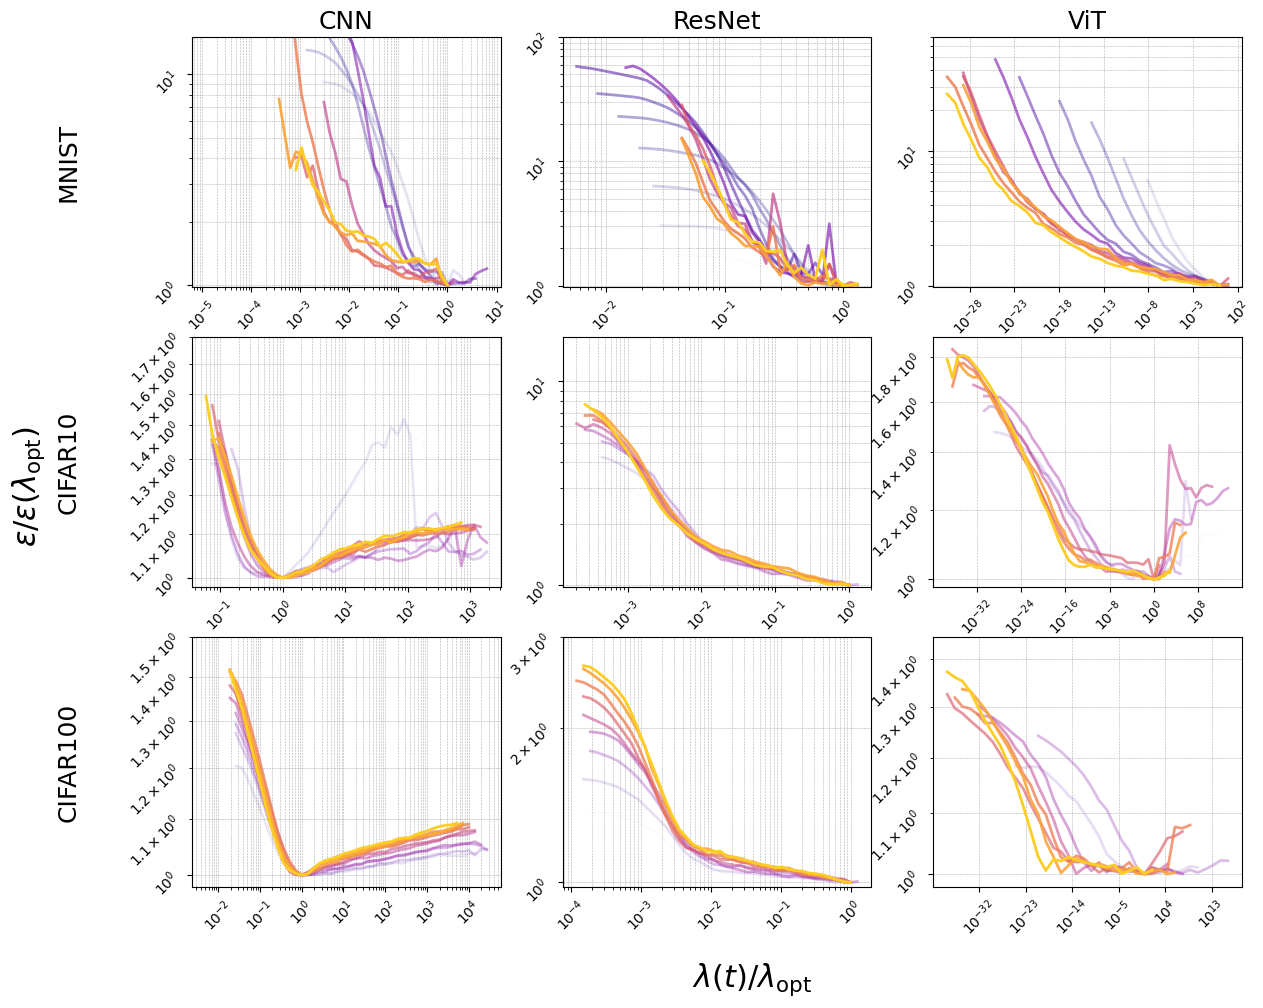

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator


def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)


ylim_values = [
    (9.8e-1, 1.5e1), (9.8e-1, 10e1), (9.8e-1, 7e1),
    (9.8e-1, 1.7), (9.8e-1, 16.5), (9.8e-1, 1.9),
    (9.8e-1, 1.5e0), (9.8e-1, 3e0), (9.8e-1, 1.45e0)
]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)

y_positions = [1 - (i + 0.5) / 3 for i in range(3)]


for i, dataset in enumerate(dataset_list):
    for j, model in enumerate(model_list):
        idx = i * 3 + j
        # Load saved results
        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]
        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i, j]

        for k in range(len(mean_val_error_arr[:,0])):
            idx_min = np.nanargmin(mean_val_error_arr[k])
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid/log_x_grid[idx_min], mean_val_error_arr[k]/(mean_val_error_arr[k][idx_min]), color=color, linewidth=2, alpha=np.min([(k/(len(P_arr)-1.))+0.01,1.]))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)


        if i == 0:
            ax.set_title(model, fontsize=18)

        if j == 0:
            ax.text(
                -0.4, 0.5, dataset,
                va='center', ha='center', rotation='vertical',
                transform=ax.transAxes, fontsize=18
            )
        ax.tick_params(axis='y', rotation=45, labelsize=12)

        ax.tick_params(axis='x', labelsize=12)

fig.text(0.5, 0., r"$\lambda(t)/\lambda_\mathrm{opt}$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"$\epsilon/\epsilon(\lambda_\mathrm{opt})$", va='center', rotation='vertical', fontsize=22)


for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()

## **With a weight decay**

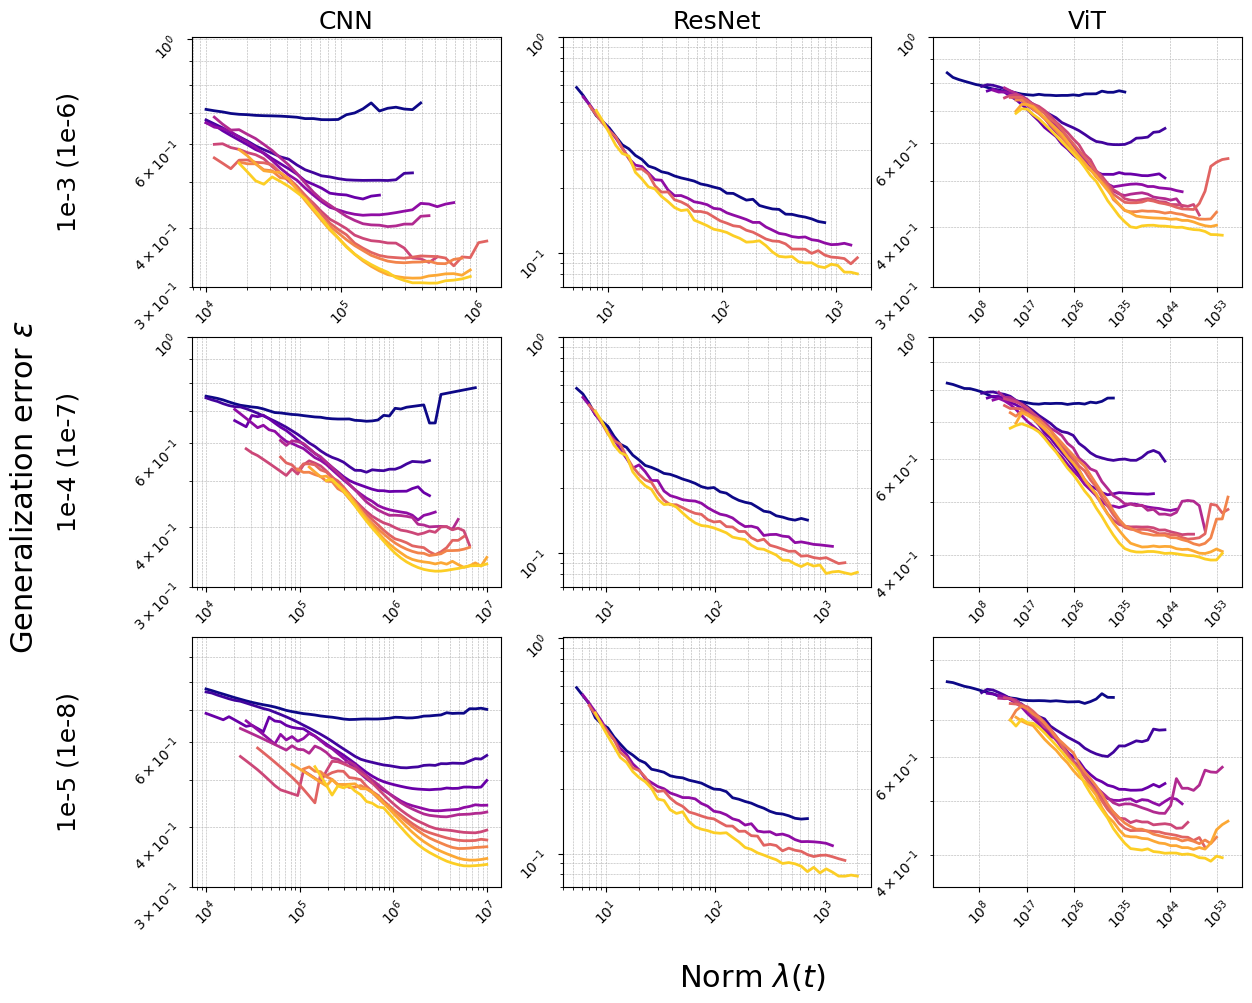

In [12]:
import numpy as np
import matplotlib.pyplot as plt


# Filenames, datasets, models, y-limits, and P arrays per dataset
name_save = [
    "CNN_CIFAR10_wd.npy", "ResNet_CIFAR10_wd.npy", "ViT_CIFAR10_wd.npy",
]
lr_list_names = ["1e-3 (1e-6)", "1e-4 (1e-7)", "1e-5 (1e-8)"]
model_list = ["CNN", "ResNet", "ViT"]
ylim_values = [
    (3e-1, 10.1e-1), (7e-2, 10e-1), (3e-1, 10e-1),
    (3.e-1, 10e-1), (7.e-2, 10e-1), (3.5e-1, 10e-1),
    (3.e-1, 9.9e-1), (7.e-2, 10.1e-1), (3.5e-1, 9.9e-1),
]



def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)

y_positions = [1 - (i + 0.5) / 3 for i in range(3)]

for i_n, norm_name in enumerate(lr_list_names):
    for j, model in enumerate(model_list):
        idx = j

        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]
        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i_n, j]


        for k in range(len(mean_val_error_arr[0,:,0])):
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid, mean_val_error_arr[i_n, k, :], color=color, linewidth=2)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx+3*i_n])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)

        if i_n == 0:
            ax.set_title(model, fontsize=18)

        if j == 0:
            ax.text(
                -0.4, 0.5, norm_name,
                va='center', ha='center', rotation='vertical',
                transform=ax.transAxes, fontsize=18
            )
        ax.tick_params(axis='y', rotation=45, labelsize=12)
        ax.tick_params(axis='x', labelsize=12)



fig.text(0.5, 0., r"Norm $\lambda(t)$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)


for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()


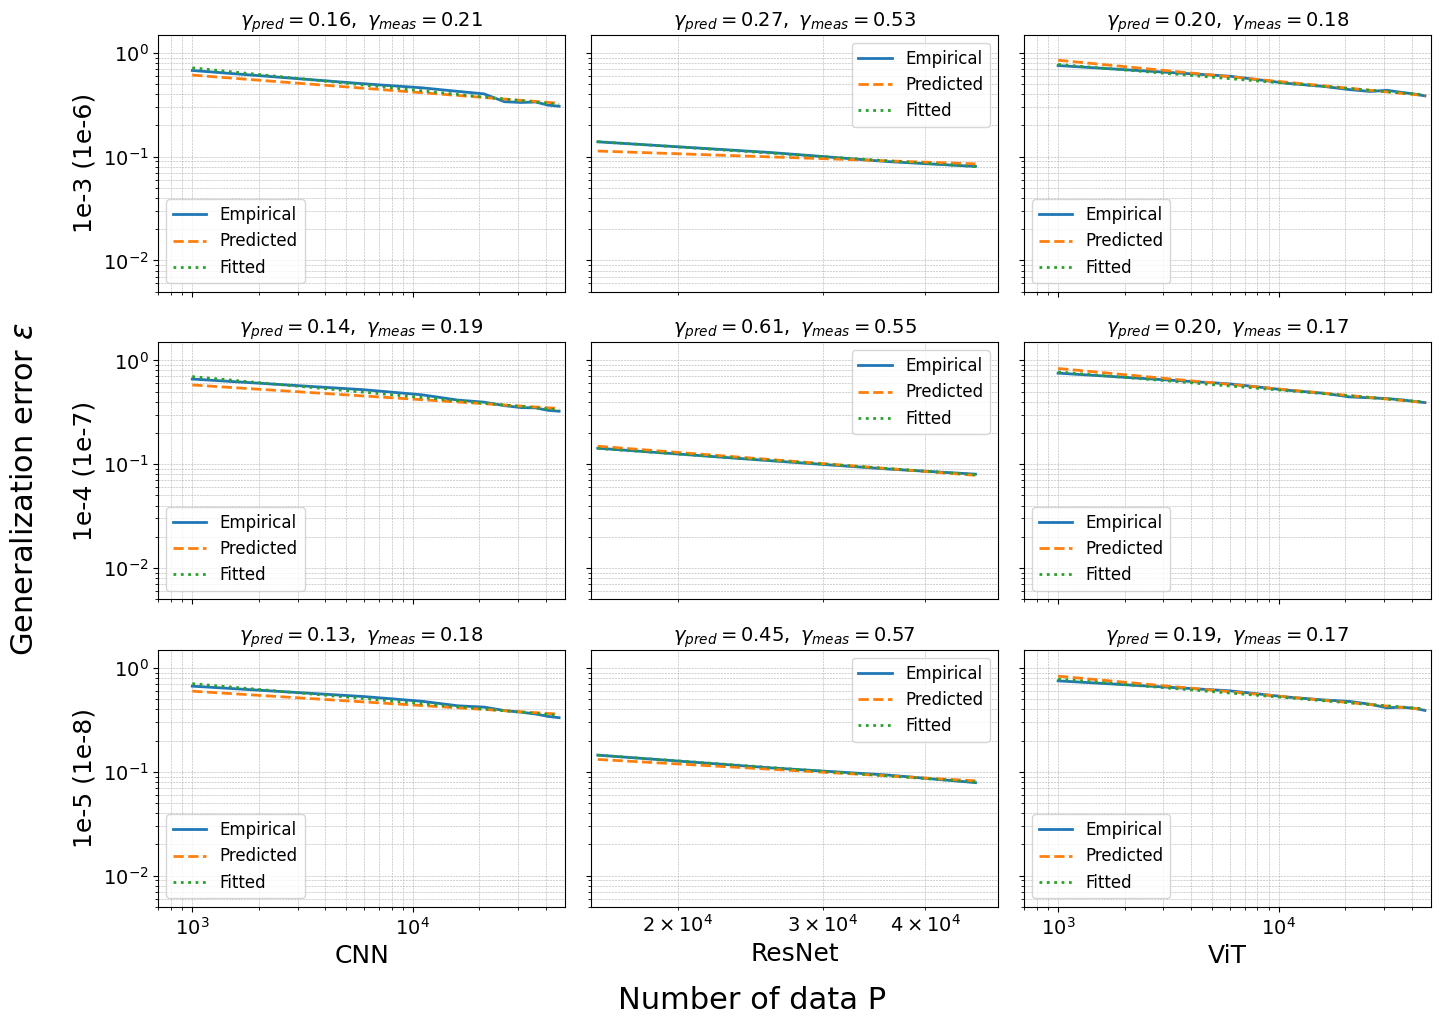

\begin{table}
\caption{Predicted vs. Measured Exponents}
\label{tab:error_exponents}
\begin{tabular}{llcc}
\toprule
Model & lr & gamma_pred & gamma_meas & stderr \\
\midrule
CNN & 1e-3 (1e-6) & 0.163 & 0.212 & 0.033 \\
CNN & 1e-4 (1e-7) & 0.136 & 0.193 & 0.050 \\
CNN & 1e-5 (1e-8) & 0.133 & 0.184 & 0.024 \\
ResNet & 1e-3 (1e-6) & 0.269 & 0.525 & 0.090 \\
ResNet & 1e-4 (1e-7) & 0.611 & 0.550 & 0.079 \\
ResNet & 1e-5 (1e-8) & 0.450 & 0.567 & 0.075 \\
ViT & 1e-3 (1e-6) & 0.205 & 0.176 & 0.014 \\
ViT & 1e-4 (1e-7) & 0.198 & 0.174 & 0.023 \\
ViT & 1e-5 (1e-8) & 0.193 & 0.173 & 0.016 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{gamma_1 and gamma_2 exponents}
\label{tab:error_exponents_2}
\begin{tabular}{llcccc}
\toprule
Model & lr & gamma_1 & err_gamma_1 & gamma_2 & err_gamma_2 \\
\midrule
CNN & 1e-3 (1e-6) & 0.2773 & 0.0184 & 0.5883 & 0.0943 \\
CNN & 1e-4 (1e-7) & 0.1880 & 0.0133 & 0.7257 & 0.2551 \\
CNN & 1e-5 (1e-8) & 0.1343 & 0.0177 & 0.9906 & 0.0815 \\
ResNet & 1e-3 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

x_to_take = [
    None, None, None,
    None, None, None,
    None, None, None
]

col_emp, col_pred, col_fit = "C0","C1","C2"
results = []
result_gamma = []


nD, nM = len(dataset_list), len(model_list)
fig, axes = plt.subplots(3, 3, figsize=(14, 10),
                        sharex="col",
                        sharey=True)
for i_n, norm_name in enumerate(lr_list_names):
    for j, model in enumerate(model_list):
        iD, iM = i_n, j
        ax = axes[i_n, iM]

        saved = np.load(data_PATH + "graphs/" + name_save[j], allow_pickle=True).item()
        if idx == 0:
            P_arr_0 = saved["P_arr"]
        P_arr = saved["P_arr"]
        eps    = saved["eps_lam_star_P_arr"][i_n]

        arr_γ1, arr_γ2 = saved["gamma_1_arr"], saved["gamma_2_arr"]
        γ1, γ2 = arr_γ1[i_n], arr_γ2[i_n]

        xt = x_to_take[idx]
        if xt is None:
            mask = np.ones_like(P_arr, dtype=bool)
        else:
            xmin, xmax = xt
            mask = (P_arr >= xmin) & (P_arr <= xmax)

        logP = np.log(P_arr[mask])
        loge = np.log(eps[mask])

        slope, intercept, _, _, stderr = linregress(logP, loge)
        fitted = np.exp(intercept) * P_arr**slope

        gamma_pred = γ1 * γ2
        gamma_meas = -slope

        err_gamma_2 = saved["err_gamma_2_arr"][i_n]
        err_gamma_1 = saved["err_gamma_1_arr"][i_n]

        err = γ1*γ2 * np.sqrt((err_gamma_1/γ1)**2 + (err_gamma_2/γ2)**2)
        final_err = np.sqrt(err**2+stderr**2)

        results.append({
            "Model":        model_list[j],
            "lr":         lr_list_names[i_n],
            "gamma_pred":   gamma_pred,
            "gamma_meas":   gamma_meas,
            "stderr":       final_err,
        })

        result_gamma.append(
            {
                "Model":        model_list[j],
                "lr":         lr_list_names[i_n],
                "gamma_1":   γ1,
                "err_gamma_1": err_gamma_1,
                "gamma_2":   γ2,
                "err_gamma_2":       err_gamma_2,
            }
        )


        ax.plot(P_arr, eps,           label="Empirical", color=col_emp, linewidth=2)

        mid = len(P_arr) // 2

        coeff_new = fitted[mid] / (P_arr[mid]**(-γ1*γ2))


        ax.plot(P_arr,
                coeff_new * (P_arr)**(-γ1*γ2),
                "--", label="Predicted", color=col_pred, linewidth=2)
        ax.plot(P_arr,
                fitted,
                ":", label="Fitted", color=col_fit, linewidth=2)

        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_ylim((5e-3,1.5))
        ax.set_xlim((P_arr.min()-300,P_arr.max()+3000))
        ax.set_title(
            rf"$\gamma_{{pred}}={gamma_pred:.2f},\ \gamma_{{meas}}={gamma_meas:.2f}$",
            fontsize=14
        )
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)
        if j == 0:     ax.set_ylabel(lr_list_names[i_n], fontsize=18)

        if i_n == 2:   ax.set_xlabel(model_list[j], fontsize=18)
        ax.legend(fontsize=12)

fig.text(0.5, -0.02, r"Number of data P", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)


plt.tight_layout()
plt.show()

# --- LaTeX table ---

df = pd.DataFrame(results)
df_sorted = df.sort_values(by=["Model"], ascending=[True])
latex = df_sorted.to_latex(
    index=False,
    float_format="%.3f",
    caption="Predicted vs. Measured Exponents",
    label="tab:error_exponents",
    column_format="llcc",
    escape=False
)
print(latex)

df = pd.DataFrame(result_gamma)
df_sorted = df.sort_values(by=["Model"], ascending=[True])
latex = df_sorted.to_latex(
    index=False,
    float_format="%.4f",
    caption="gamma_1 and gamma_2 exponents",
    label="tab:error_exponents_2",
    column_format="llcccc",
    escape=False
)
print(latex)

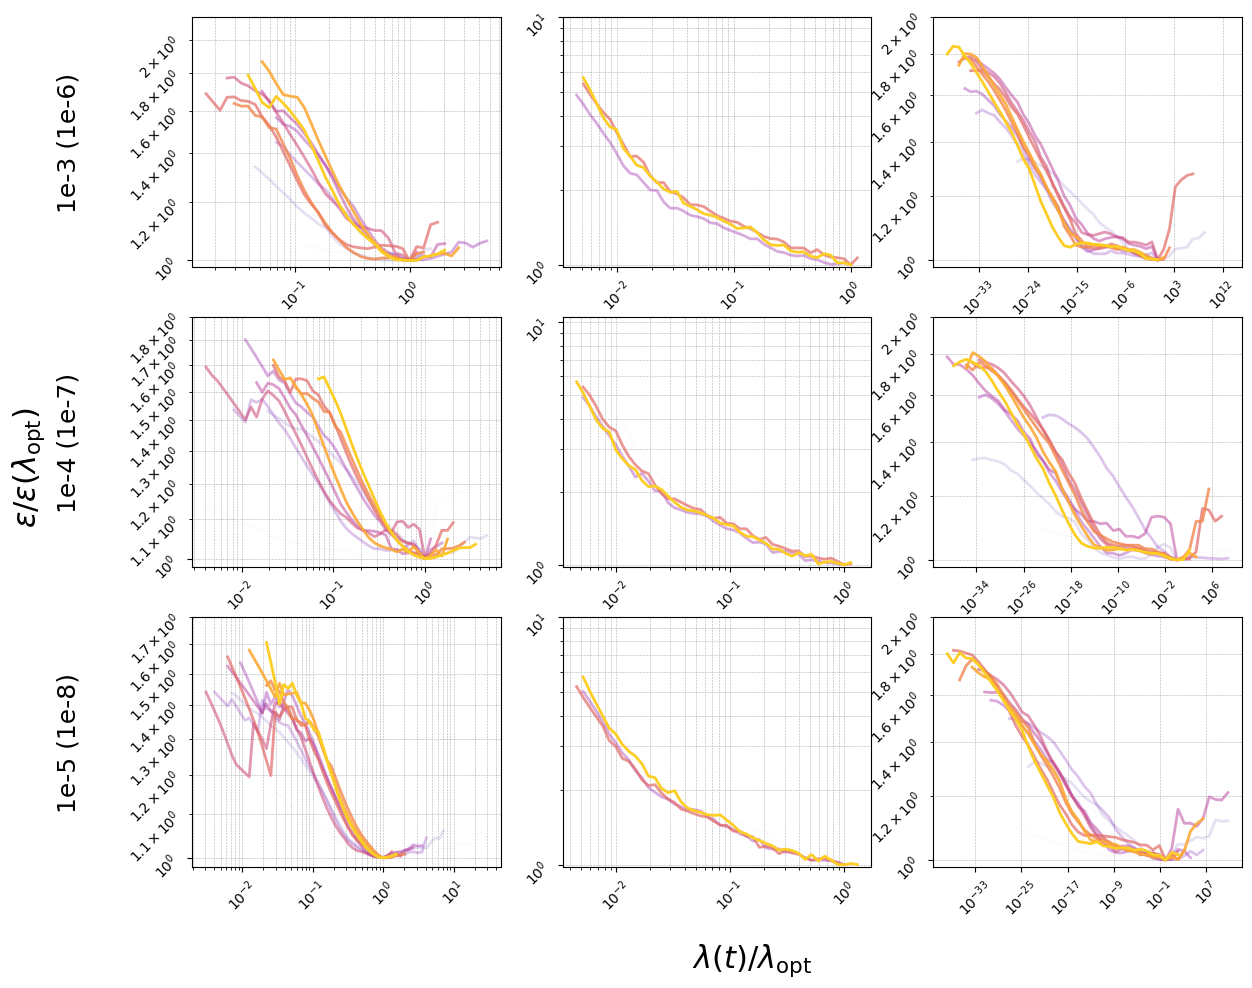

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator
def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)


ylim_values = [
    (9.8e-1, 2.15e0), (9.8e-1, 10e0), (9.8e-1, 2),
    (9.8e-1, 1.8),   (9.8e-1, 10.5), (9.8e-1, 2),
    (9.8e-1, 1.7e0), (9.8e-1, 10),  (9.8e-1,  2)
]

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)


y_positions = [1 - (i + 0.5) / 3 for i in range(3)]


for i_n, norm_name in enumerate(lr_list_names):
    for j, model in enumerate(model_list):
        idx = j

        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]

        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i_n, j]

        for k in range(len(mean_val_error_arr[i_n,:,0])):
            idx_min = np.nanargmin(mean_val_error_arr[i_n,k])
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid/log_x_grid[idx_min], mean_val_error_arr[i_n,k]/(mean_val_error_arr[i_n, k, idx_min]), color=color, linewidth=2, alpha=np.min([(k/(len(P_arr)-1.))+0.01,1.]))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx+i_n*3])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)


        if i == 0:
            ax.set_title(model, fontsize=18)

        if j == 0:
            ax.text(
                -0.4, 0.5, norm_name,
                va='center', ha='center', rotation='vertical',
                transform=ax.transAxes, fontsize=18
            )
        ax.tick_params(axis='y', rotation=45, labelsize=12)
        ax.tick_params(axis='x', labelsize=12)

fig.text(0.5, 0., r"$\lambda(t)/\lambda_\mathrm{opt}$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"$\epsilon/\epsilon(\lambda_\mathrm{opt})$", va='center', rotation='vertical', fontsize=22)

for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()

## **Using SGD instead of Adam**

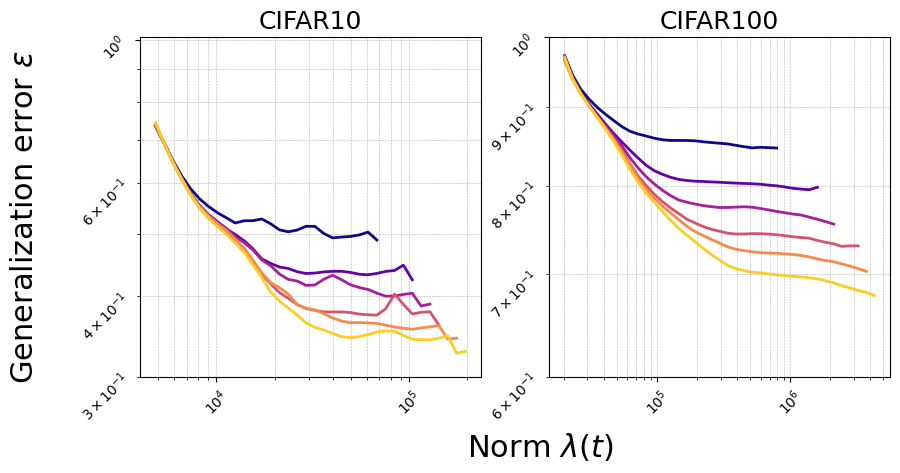

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


name_save = [
    "CNN_CIFAR10_SGD.npy", "CNN_CIFAR100_SGD.npy"
]
dataset_list = ["CIFAR10", "CIFAR100"]
model_list = ["CNN"]
ylim_values = [
    (3e-1, 10.1e-1), (6e-1, 10e-1)
]
# p_values_list = [
#     np.array([94, 188, 375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000]),
#     np.array([12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000]),
#     np.array([12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000, 44000, 48000])
# ]

def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)


y_positions = [1 - (i + 0.5) / 3 for i in range(3)]


for i, dataset in enumerate(dataset_list):
    for j, model in enumerate(model_list):
        idx = j * 3 + i

        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]
        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i]

        for k in range(len(mean_val_error_arr[:,0])):
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid, mean_val_error_arr[k], color=color, linewidth=2)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)

        if j == 0:
            ax.set_title(dataset, fontsize=18)


        ax.tick_params(axis='y', rotation=45, labelsize=12)

        ax.tick_params(axis='x', labelsize=12)


fig.text(0.5, -0.10, r"Norm $\lambda(t)$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)

for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()


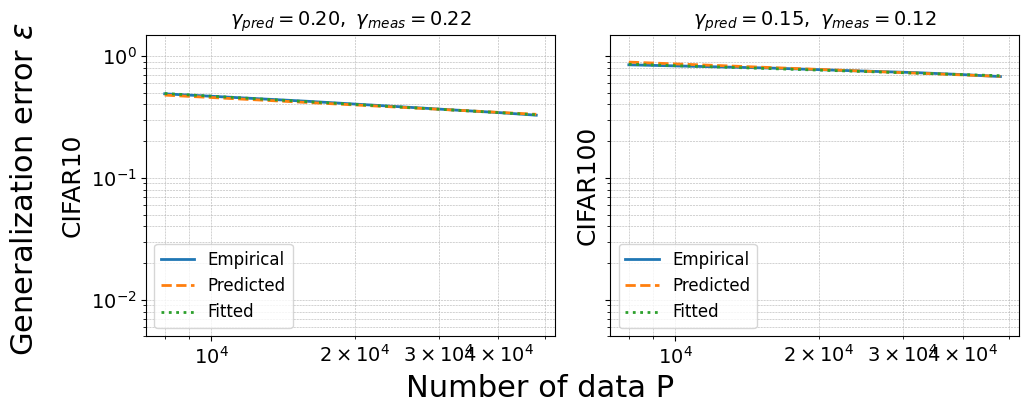

\begin{table}
\caption{Predicted vs. Measured Exponents}
\label{tab:error_exponents}
\begin{tabular}{llcc}
\toprule
Model & Dataset & gamma_pred & gamma_meas & stderr \\
\midrule
CNN & CIFAR10 & 0.202 & 0.225 & 0.047 \\
CNN & CIFAR100 & 0.150 & 0.122 & 0.013 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{gamma_1 and gamma_2 exponents}
\label{tab:error_exponents_2}
\begin{tabular}{llcccc}
\toprule
Model & Dataset & gamma_1 & err_gamma_1 & gamma_2 & err_gamma_2 \\
\midrule
CNN & CIFAR10 & 0.4735 & 0.0268 & 0.4276 & 0.0962 \\
CNN & CIFAR100 & 0.1469 & 0.0098 & 1.0233 & 0.0170 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

x_to_take = [
    None, None, None,
    None, None, None,
    None, None, None
]

col_emp, col_pred, col_fit = "C0","C1","C2"
results = []
result_gamma = []


nD, nM = len(dataset_list), len(model_list)
fig, axes = plt.subplots(nM, nD, figsize=(10, 4),
                        sharex="row",   # share only within each row
                        sharey=True)

for idx, fname in enumerate(name_save):
    iD, iM = divmod(idx, nM)
    ax = axes[iD]

    saved = np.load(data_PATH + "graphs/" + fname, allow_pickle=True).item()
    if idx == 0:
        P_arr_0 = saved["P_arr"]
    P_arr = saved["P_arr"]
    eps    = saved["eps_lam_star_P_arr"]

    γ1, γ2 = saved["gamma_1"], saved["gamma_2"]

    # build selection mask
    xt = x_to_take[idx]
    if xt is None:
        mask = np.ones_like(P_arr, dtype=bool)
    else:
        xmin, xmax = xt
        mask = (P_arr >= xmin) & (P_arr <= xmax)

    logP = np.log(P_arr[mask])
    loge = np.log(eps[mask])

    slope, intercept, _, _, stderr = linregress(logP, loge)
    fitted = np.exp(intercept) * P_arr**slope

    gamma_pred = γ1 * γ2
    gamma_meas = -slope

    err_gamma_2 = saved["err_gamma_2"]
    err_gamma_1 = saved["err_gamma_1"]

    err = γ1*γ2 * np.sqrt((err_gamma_1/γ1)**2 + (err_gamma_2/γ2)**2)

    final_err = np.sqrt(err**2+stderr**2)

    results.append({
        "Model":        model_list[iM],
        "Dataset":      dataset_list[iD],
        "gamma_pred":   gamma_pred,
        "gamma_meas":   gamma_meas,
        "stderr":       final_err,
    })

    result_gamma.append(
        {
            "Model":        model_list[iM],
            "Dataset":      dataset_list[iD],
            "gamma_1":   γ1,
            "err_gamma_1": err_gamma_1,
            "gamma_2":   γ2,
            "err_gamma_2":       err_gamma_2,
        }
    )


    ax.plot(P_arr, eps,           label="Empirical", color=col_emp, linewidth=2)

    mid = len(P_arr) // 2


    coeff_new = fitted[mid] / (P_arr[mid]**(-γ1*γ2))


    ax.plot(P_arr,
            coeff_new * (P_arr)**(-γ1*γ2),
            "--", label="Predicted", color=col_pred, linewidth=2)
    ax.plot(P_arr,
            fitted,
            ":", label="Fitted", color=col_fit, linewidth=2)

    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_ylim((5e-3,1.5))

    ax.set_title(
        rf"$\gamma_{{pred}}={gamma_pred:.2f},\ \gamma_{{meas}}={gamma_meas:.2f}$",
        fontsize=14
    )
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)
    if iM == 0:     ax.set_ylabel(dataset_list[iD], fontsize=18)

    if iD == 2:   ax.set_xlabel(model_list[iM], fontsize=18)
    ax.legend(fontsize=12)


fig.text(0.5, -0.02, r"Number of data P", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)


plt.tight_layout()
plt.show()

# --- LaTeX table ---
df = pd.DataFrame(results)
df_sorted = df.sort_values(by=["Model"], ascending=[True])

latex = df_sorted.to_latex(
    index=False,
    float_format="%.3f",
    caption="Predicted vs. Measured Exponents",
    label="tab:error_exponents",
    column_format="llcc",
    escape=False
)
print(latex)

df = pd.DataFrame(result_gamma)
df_sorted = df.sort_values(by=["Model"], ascending=[True])

latex = df_sorted.to_latex(
    index=False,
    float_format="%.4f",
    caption="gamma_1 and gamma_2 exponents",
    label="tab:error_exponents_2",
    column_format="llcccc",
    escape=False
)
print(latex)


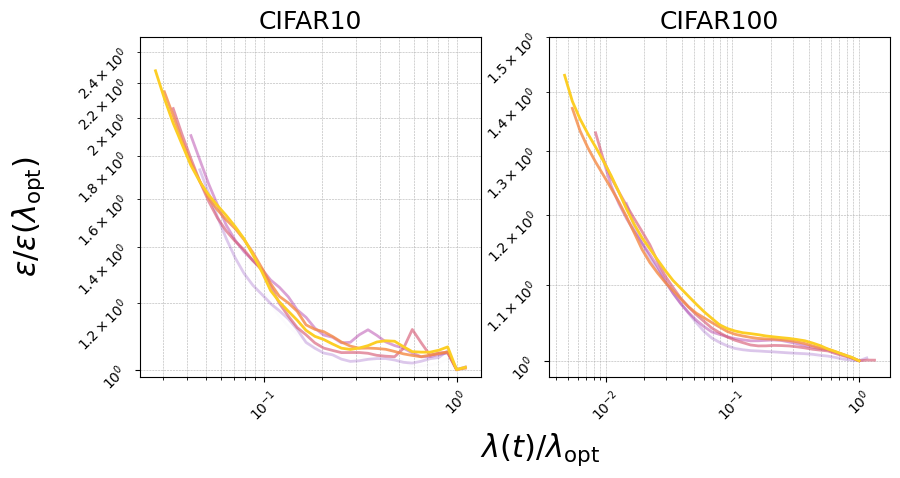

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator


def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)


ylim_values = [
    (9.8e-1, 2.5e0), (9.8e-1, 1.5e0),
]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)


y_positions = [1 - (i + 0.5) / 3 for i in range(3)]


for i, dataset in enumerate(dataset_list):
    for j, model in enumerate(model_list):
        idx = j * 3 + i

        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]
        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i]

        for k in range(len(mean_val_error_arr[:,0])):
            idx_min = np.nanargmin(mean_val_error_arr[k])
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid/log_x_grid[idx_min], mean_val_error_arr[k]/(mean_val_error_arr[k][idx_min]), color=color, linewidth=2, alpha=np.min([(k/(len(P_arr)-1.))+0.01,1.]))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[i])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)


        if j == 0:
            ax.set_title(dataset, fontsize=18)


        ax.tick_params(axis='y', rotation=45, labelsize=12)

        ax.tick_params(axis='x', labelsize=12)


fig.text(0.5, -0.1, r"$\lambda(t)/\lambda_\mathrm{opt}$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"$\epsilon/\epsilon(\lambda_\mathrm{opt})$", va='center', rotation='vertical', fontsize=22)


for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()

## **Measuring other norms**

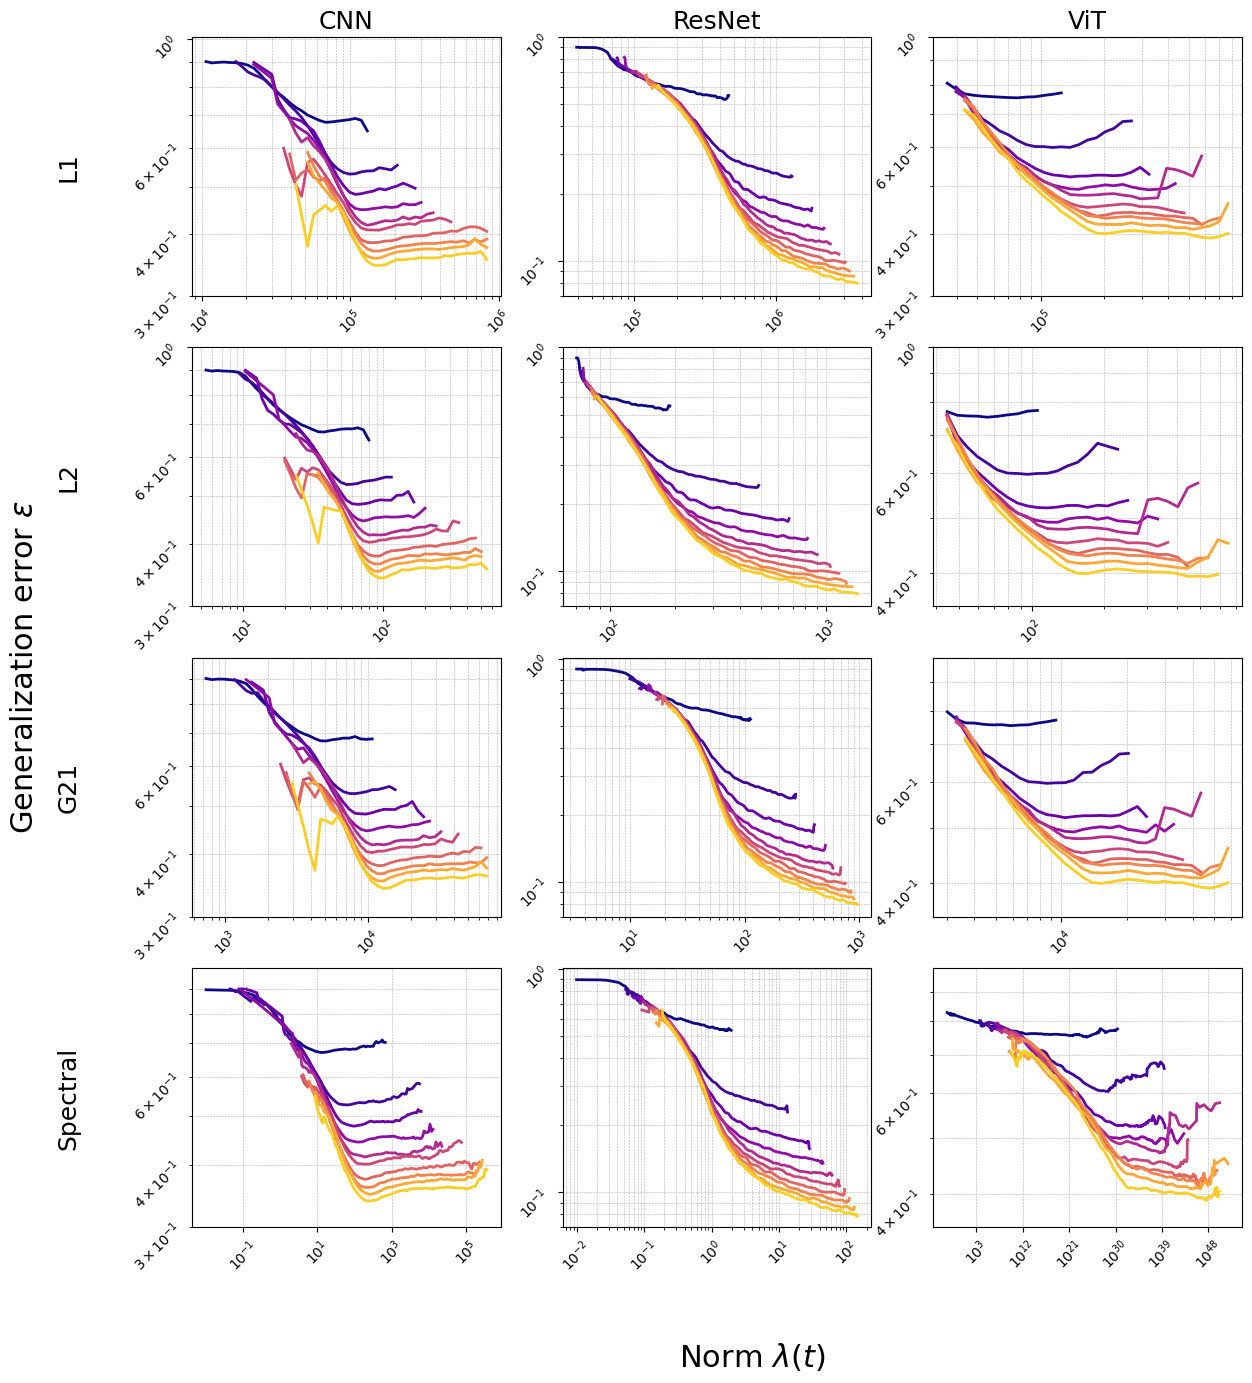

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Filenames, datasets, models, y-limits, and P arrays per dataset
name_save = [
    "CNN_CIFAR10_norms.npy", "ResNet_CIFAR10_norms.npy", "ViT_CIFAR10_norms.npy",
]
norms_list = ["L1", "L2", "G21", "Spectral"]
model_list = ["CNN", "ResNet", "ViT"]
ylim_values = [
    (3e-1, 10.1e-1), (7e-2, 10e-1), (3e-1, 10e-1),
    (3.e-1, 10e-1), (7.e-2, 10e-1), (3.5e-1, 10e-1),
    (3.e-1, 9.9e-1), (7.e-2, 10.1e-1), (3.5e-1, 9.9e-1),
    (3.e-1, 9.9e-1), (7.e-2, 10.1e-1), (3.5e-1, 9.9e-1)
]


def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)


fig, axes = plt.subplots(4, 3, figsize=(14, 14))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)


y_positions = [1 - (i + 0.5) / 3 for i in range(3)]


for i_n, norm_name in enumerate(norms_list):
    for j, model in enumerate(model_list):
        idx = j

        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]
        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i_n, j]

        for k in range(len(mean_val_error_arr[0,:,0])):
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid, mean_val_error_arr[i_n, k, :], color=color, linewidth=2)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx+3*i_n])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)


        if i_n == 0:
            ax.set_title(model, fontsize=18)

        if j == 0:
            ax.text(
                -0.4, 0.5, norm_name,
                va='center', ha='center', rotation='vertical',
                transform=ax.transAxes, fontsize=18
            )
        ax.tick_params(axis='y', rotation=45, labelsize=12)

        ax.tick_params(axis='x', labelsize=12)


fig.text(0.5, 0., r"Norm $\lambda(t)$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)


for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()


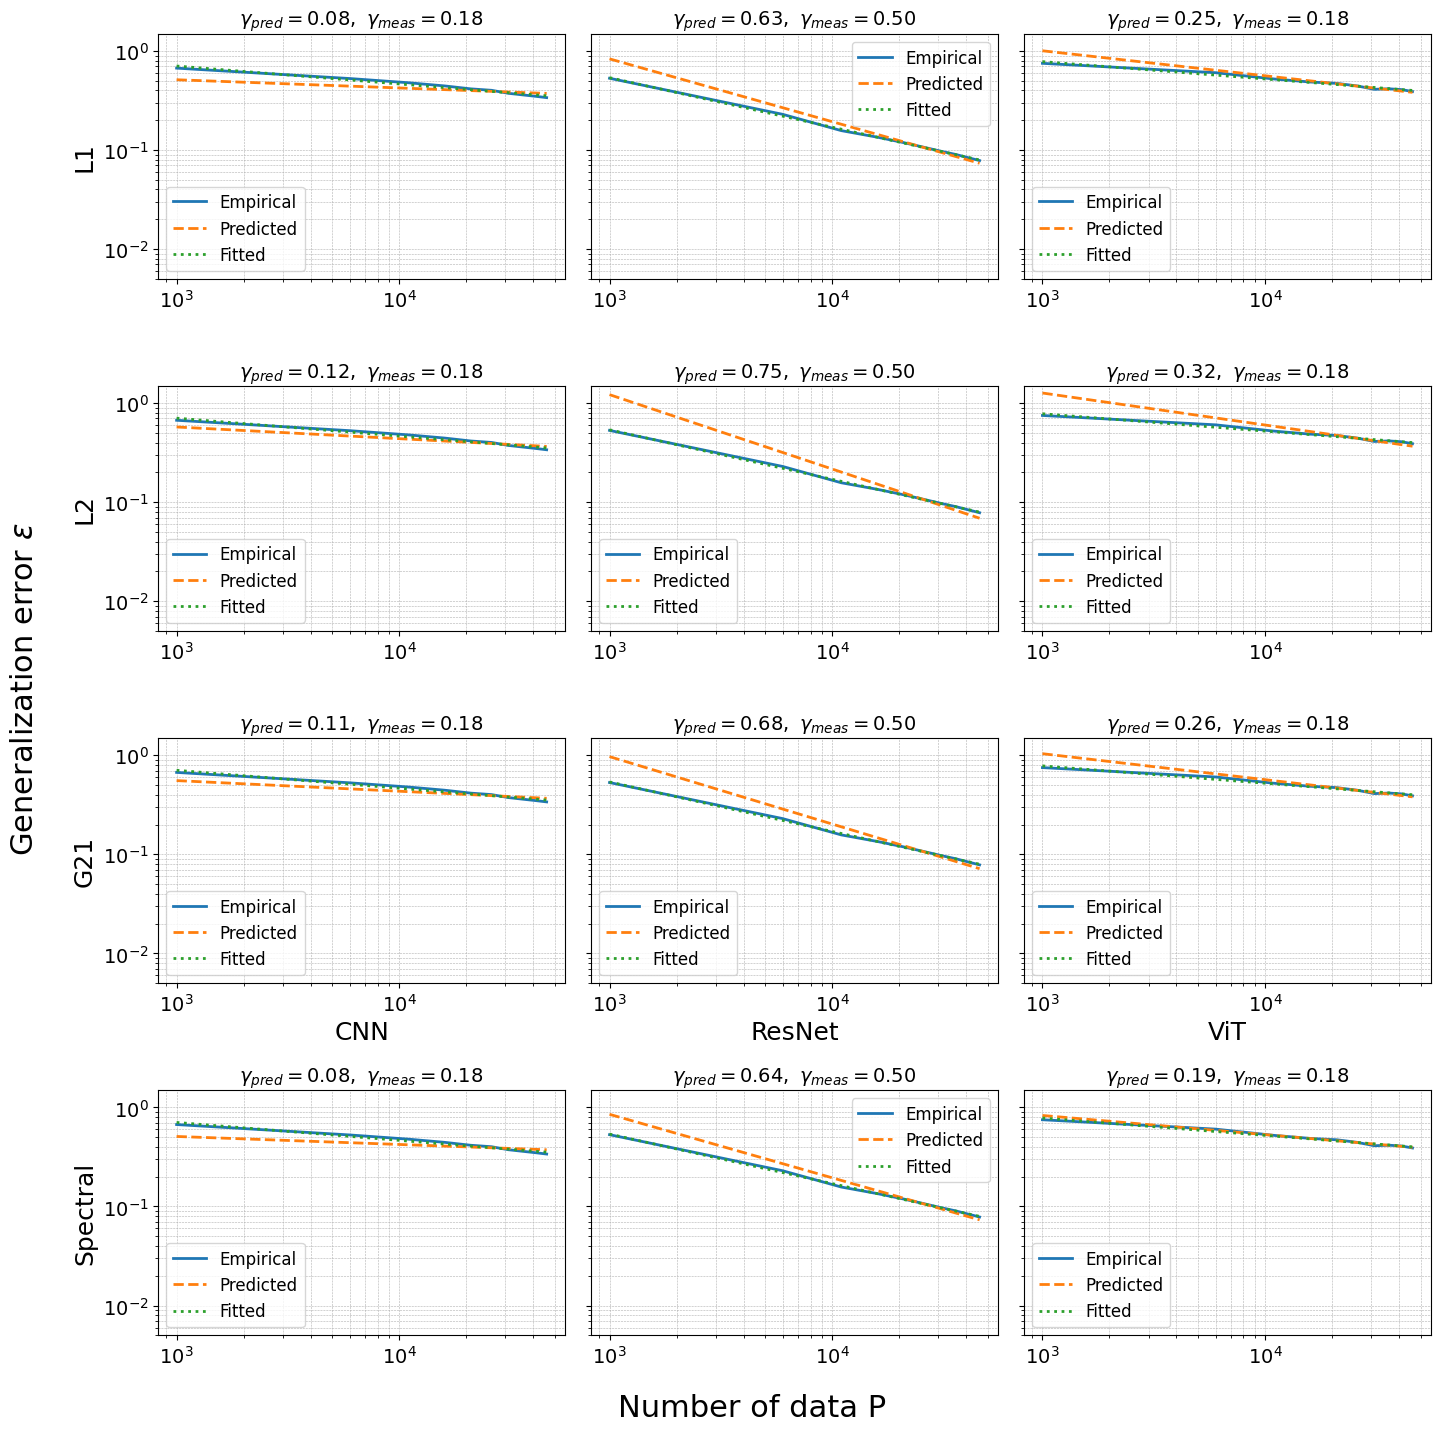

\begin{table}
\caption{Predicted vs. Measured Exponents}
\label{tab:error_exponents}
\begin{tabular}{llcc}
\toprule
Model & Norm & gamma_pred & gamma_meas & stderr \\
\midrule
CNN & L1 & 0.083 & 0.181 & 0.023 \\
CNN & L2 & 0.118 & 0.181 & 0.028 \\
CNN & G21 & 0.107 & 0.181 & 0.026 \\
CNN & Spectral & 0.081 & 0.181 & 0.042 \\
ResNet & L1 & 0.634 & 0.500 & 0.013 \\
ResNet & L2 & 0.750 & 0.500 & 0.013 \\
ResNet & G21 & 0.680 & 0.500 & 0.018 \\
ResNet & Spectral & 0.641 & 0.500 & 0.011 \\
ViT & L1 & 0.252 & 0.175 & 0.027 \\
ViT & L2 & 0.323 & 0.175 & 0.040 \\
ViT & G21 & 0.262 & 0.175 & 0.028 \\
ViT & Spectral & 0.193 & 0.175 & 0.018 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{gamma_1 and gamma_2 exponents}
\label{tab:error_exponents_2}
\begin{tabular}{llcccc}
\toprule
Model & Norm & gamma_1 & err_gamma_1 & gamma_2 & err_gamma_2 \\
\midrule
CNN & L1 & 0.5687 & 0.0300 & 0.1458 & 0.0358 \\
CNN & L2 & 0.5894 & 0.0157 & 0.2000 & 0.0426 \\
CNN & G21 & 0.5482 & 0.0187 & 0.19

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

x_to_take = [
    None, None, None,
    None, None, None,
    None, None, None
]

col_emp, col_pred, col_fit = "C0","C1","C2"
results = []
result_gamma = []


nD, nM = len(dataset_list), len(model_list)
fig, axes = plt.subplots(4, 3, figsize=(14, 14),
                        sharex="row",   # share only within each row
                        sharey=True)
for i_n, norm_name in enumerate(norms_list):
    for j, model in enumerate(model_list):
        iD, iM = i_n, j
        ax = axes[i_n, iM]

        saved = np.load(data_PATH + "graphs/" + name_save[j], allow_pickle=True).item()
        if idx == 0:
            P_arr_0 = saved["P_arr"]
        P_arr = saved["P_arr"]
        eps    = saved["eps_lam_star_P_arr"]

        arr_γ1, arr_γ2 = saved["gamma_1_arr"], saved["gamma_2_arr"]
        γ1, γ2 = arr_γ1[i_n], arr_γ2[i_n]

        # build selection mask
        xt = x_to_take[idx]
        if xt is None:
            mask = np.ones_like(P_arr, dtype=bool)
        else:
            xmin, xmax = xt
            mask = (P_arr >= xmin) & (P_arr <= xmax)

        logP = np.log(P_arr[mask])
        loge = np.log(eps[mask])

        slope, intercept, _, _, stderr = linregress(logP, loge)
        fitted = np.exp(intercept) * P_arr**slope

        gamma_pred = γ1 * γ2
        gamma_meas = -slope

        err_gamma_2 = saved["err_gamma_2_arr"][i_n]
        err_gamma_1 = saved["err_gamma_1_arr"][i_n]

        err = γ1*γ2 * np.sqrt((err_gamma_1/γ1)**2 + (err_gamma_2/γ2)**2)

        final_err = np.sqrt(err**2+stderr**2)

        results.append({
            "Model":        model_list[j],
            "Norm":         norms_list[i_n],
            "gamma_pred":   gamma_pred,
            "gamma_meas":   gamma_meas,
            "stderr":       final_err,
        })

        result_gamma.append(
            {
                "Model":        model_list[j],
                "Norm":         norms_list[i_n],
                "gamma_1":   γ1,
                "err_gamma_1": err_gamma_1,
                "gamma_2":   γ2,
                "err_gamma_2":       err_gamma_2,
            }
        )


        ax.plot(P_arr, eps,           label="Empirical", color=col_emp, linewidth=2)

        mid = len(P_arr) // 2

        coeff_new = fitted[mid] / (P_arr[mid]**(-γ1*γ2))

        ax.plot(P_arr,
                coeff_new * (P_arr)**(-γ1*γ2),
                "--", label="Predicted", color=col_pred, linewidth=2)
        ax.plot(P_arr,
                fitted,
                ":", label="Fitted", color=col_fit, linewidth=2)

        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_ylim((5e-3,1.5))

        ax.set_title(
            rf"$\gamma_{{pred}}={gamma_pred:.2f},\ \gamma_{{meas}}={gamma_meas:.2f}$",
            fontsize=14
        )
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)
        if j == 0:     ax.set_ylabel(norms_list[i_n], fontsize=18)

        if i_n == 2:   ax.set_xlabel(model_list[j], fontsize=18)
        ax.legend(fontsize=12)


fig.text(0.5, -0.02, r"Number of data P", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"Generalization error $\epsilon$", va='center', rotation='vertical', fontsize=22)


plt.tight_layout()
plt.show()

# --- LaTeX table ---
df = pd.DataFrame(results)
df_sorted = df.sort_values(by=["Model"], ascending=[True])

latex = df_sorted.to_latex(

    index=False,
    float_format="%.3f",
    caption="Predicted vs. Measured Exponents",
    label="tab:error_exponents",
    column_format="llcc",
    escape=False
)
print(latex)

df = pd.DataFrame(result_gamma)
df_sorted = df.sort_values(by=["Model"], ascending=[True])



latex = df_sorted.to_latex(
    index=False,
    float_format="%.4f",
    caption="gamma_1 and gamma_2 exponents",
    label="tab:error_exponents_2",
    column_format="llcccc",
    escape=False
)
print(latex)

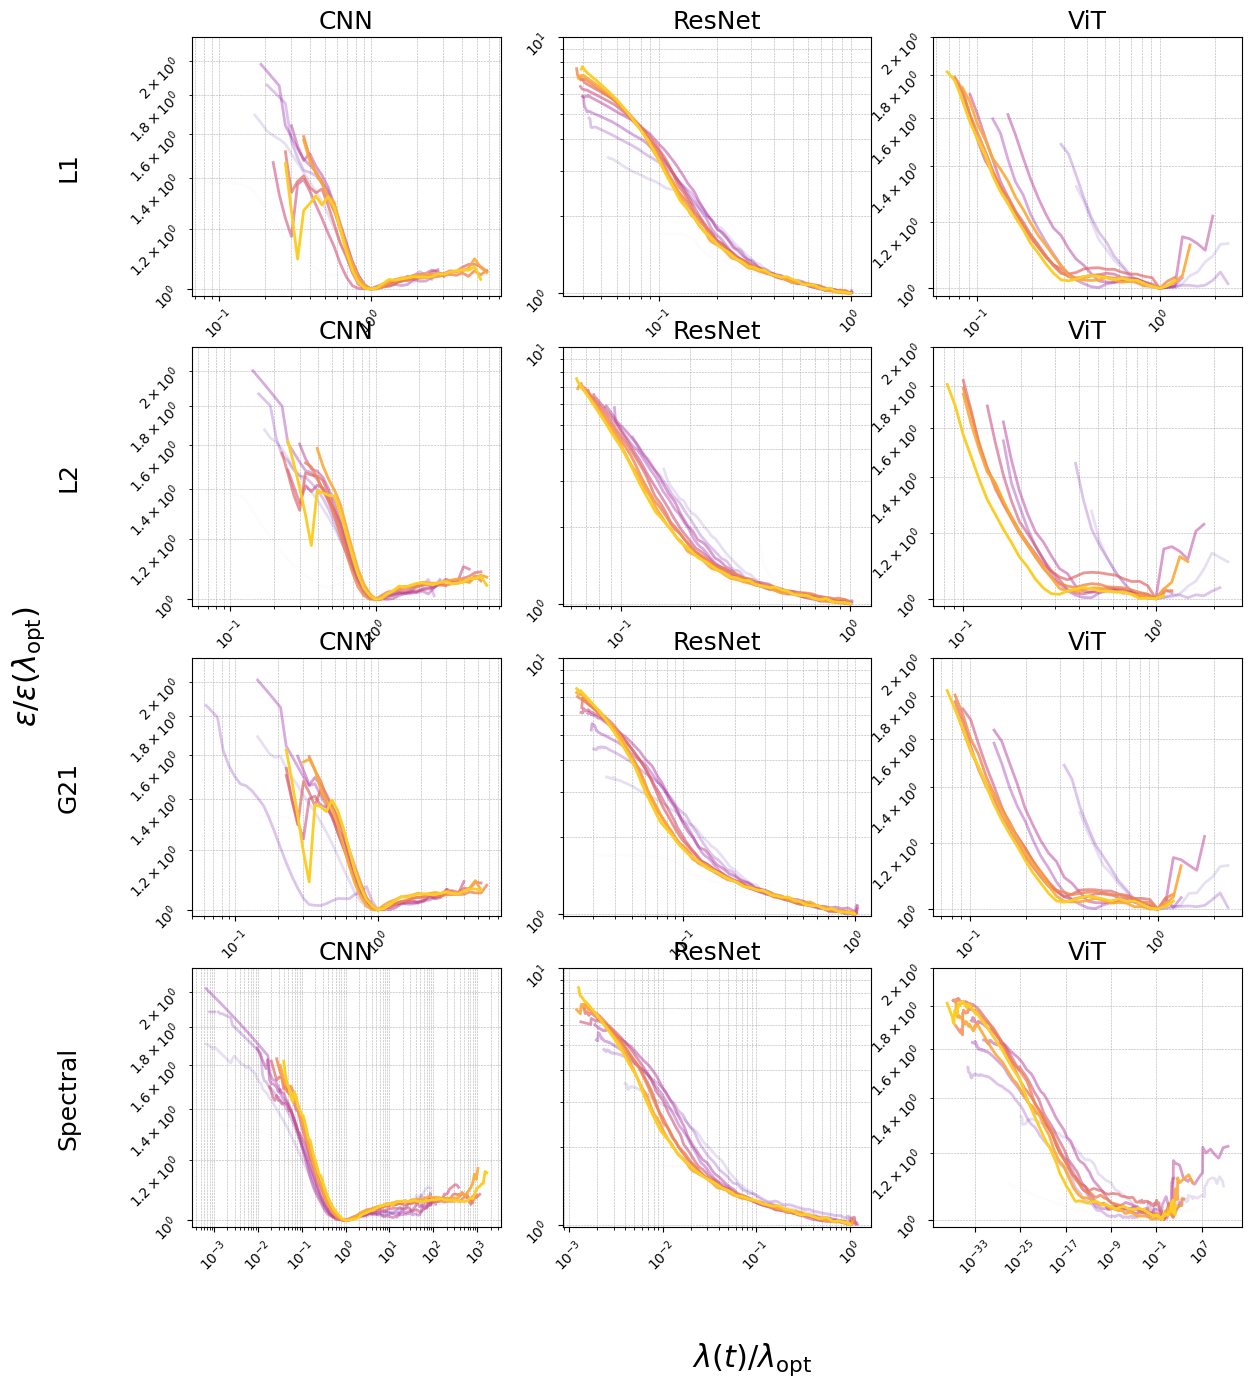

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator


def truncate_colormap(cmap_in, minval=0.0, maxval=0.9, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap_in.name},{minval:.2f},{maxval:.2f})',
        cmap_in(np.linspace(minval, maxval, n))
    )
    return new_cmap

base_cmap = colormaps['plasma']
cmap = truncate_colormap(base_cmap, 0.0, 0.9)


ylim_values = [
    (9.8e-1, 2.15e0), (9.8e-1, 10e0), (9.8e-1, 2),
    (9.8e-1, 2.17),   (9.8e-1, 10.5), (9.8e-1, 2),
    (9.8e-1, 2.15e0), (9.8e-1, 10),  (9.8e-1,  2)
]


fig, axes = plt.subplots(4, 3, figsize=(14, 14))
fig.subplots_adjust(right=0.85, left=0.1, top=0.95, bottom=0.1)


y_positions = [1 - (i + 0.5) / 3 for i in range(3)]

for i_n, norm_name in enumerate(norms_list):
    for j, model in enumerate(model_list):
        idx = j
        # Load saved results
        saved = np.load(data_PATH + "graphs/" + name_save[idx], allow_pickle=True).item()
        log_x_grid = saved["log_x_grid"]
        mean_val_error_arr = saved["mean_val_error_arr"]

        P_arr = saved["P_arr"]

        norm = Normalize(vmin=min(P_arr), vmax=max(P_arr))

        ax = axes[i_n, j]

        for k in range(len(mean_val_error_arr[i_n,:,0])):
            idx_min = np.nanargmin(mean_val_error_arr[i_n,k])
            color = cmap(norm(P_arr[k]))
            ax.plot(log_x_grid/log_x_grid[idx_min], mean_val_error_arr[i_n,k]/(mean_val_error_arr[i_n, k, idx_min]), color=color, linewidth=2, alpha=np.min([(k/(len(P_arr)-1.))+0.01,1.]))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(ylim_values[idx])
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)


        if i == 0:
            ax.set_title(model, fontsize=18)

        if j == 0:
            ax.text(
                -0.4, 0.5, norm_name,
                va='center', ha='center', rotation='vertical',
                transform=ax.transAxes, fontsize=18
            )
        ax.tick_params(axis='y', rotation=45, labelsize=12)

        ax.tick_params(axis='x', labelsize=12)


# Shared axis labels
fig.text(0.5, 0., r"$\lambda(t)/\lambda_\mathrm{opt}$", ha='center', fontsize=22)
fig.text(-0.03, 0.5, r"$\epsilon/\epsilon(\lambda_\mathrm{opt})$", va='center', rotation='vertical', fontsize=22)


for ax in axes.flatten():

    ax.tick_params(
        axis='both',
        which='major',
        labelsize=10,
        rotation=45
    )
    ax.tick_params(
        axis='both',
        which='minor',
        labelsize=10,
        rotation=45
    )

plt.show()

## Combination of power laws

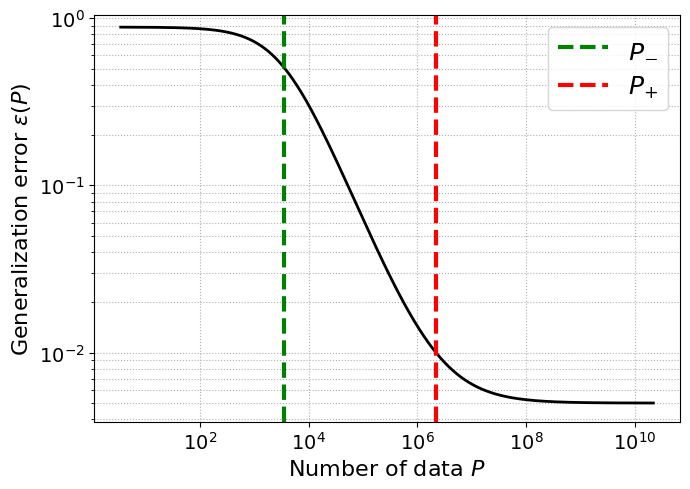

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# parameters  (edit γ, γ_P if you wish)
k1, q1 = 35, 0.005
k2, q2 = 0.0288, 100
gamma      = 0.8      # outer exponent γ
gamma_P    = 1.      # inner exponent γ_P
# ---------------------------------------------------------------------


P_minus = (q2 / k2) ** (1.0 / gamma_P)
P_plus  = (k1 * k2**(-gamma) / q1) ** (1.0 / (gamma * gamma_P))


def eps(P):
    return k1 * (k2 * P**gamma_P + q2)**(-gamma) + q1

P = np.logspace(
        np.log10(P_minus) - 3,
        np.log10(P_plus)  + 4,
        num=1200
    )

# plot ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.loglog(P, eps(P), color="black",lw=2)

# vertical dashed lines at P- and P+
plt.axvline(P_minus, ls='--', color='Green', label=r'$P_{-}$',lw=3)
plt.axvline(P_plus,  ls='--', color='Red', label=r'$P_{+}$',lw=3)

plt.xlabel(r"Number of data $P$", fontsize=16)
plt.ylabel(r"Generalization error $\epsilon(P)$", fontsize=16)
plt.grid(True, which="both", ls=":")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)

plt.legend(fontsize=18)
plt.ylim(top=1.05)
plt.tight_layout()
plt.show()